In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=8, num_layers=6):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.decoder = nn.Linear(d_model, input_dim)
    
    def forward(self, x, return_features=False):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        if return_features:
            return x
        x = self.decoder(x)
        return x

# Load the checkpoint
# checkpoint = torch.load('pretrained_model.pth')

# Extract the model state dictionary
# model_state_dict = checkpoint['model_state_dict']

# # Ensure input_dim and hidden_dim match your model definition
# input_dim = checkpoint['input_dim']
# hidden_dim = checkpoint['hidden_dim']

# # Initialize your model
# pretrained_model = TransformerModel(input_dim)

# # Load the state dictionary into the model
# pretrained_model.load_state_dict(model_state_dict)
# pretrained_model
# # Set the model to evaluation mode if necessary
# pretrained_model.eval()

# # Move the model to the appropriate device if necessary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# pretrained_model.to(device)
# pretrained_model

In [18]:
import torch.nn as nn
class EnhancedMLP(nn.Module):
    def __init__(self, pretrained_model, input_size, hidden_size, num_classes):
        super(EnhancedMLP, self).__init__()
        self.pretrained_model = pretrained_model
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        # print(x.shape)
        x = self.pretrained_model(x, return_features=True)
        # print(x.shape)
        x = torch.nn.functional.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        return x

In [19]:
# Load the state dictionary

# d_model = 64
input_dim = 22
# # nhead = 8
# # num_layers = 6
hidden_dim = 128
num_classes = 2
# # # Initialize your model
pretrained_model = TransformerModel(input_dim)
state_dict = torch.load('pretrained_model.pth')
pretrained_model.load_state_dict(state_dict)
pretrained_model
# pretrained_model.load_state_dict(torch.load('pretrained_model.pth'))
# # pretrained_model.to(device)
# pretrained_model.eval()  # 设置为评估模式

input_d = 64
# # 初始化EnhancedMLP模型并移动到GPU
enhanced_mlp = EnhancedMLP(pretrained_model, input_d, hidden_dim, num_classes).to(device)

# # 定义损失函数和优化器
# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(enhanced_mlp.parameters(), lr=0.0001)
enhanced_mlp


EnhancedMLP(
  (pretrained_model): TransformerModel(
    (embedding): Linear(in_features=22, out_features=64, bias=True)
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): Linear(in_features=64, out_features=22, bias=True)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
# Read the data into a DataFrame
df = pd.read_csv("NSCLC.csv")
# Filter out columns that contain all zeros
# df = df.loc[:, (NSCLC != 0).any(axis=0)]
f1 = pd.read_csv('genus_rotated_f_filtered.csv')
# print(f1.shape)
# Extract genus-level data
df['Genus'] = df['#NAME'].apply(lambda x: x.split(';g__')[1].split(';')[0] if ';g__' in x else 'Unclassified')

# Select the relevant columns
genus_df = df[['Genus'] + df.columns[1:-1].tolist()]

# Filter out rows with "_unclassified" in the Genus column
NSCLC = genus_df[~genus_df['Genus'].str.contains('_unclassified')]
if 'Genus' in NSCLC.columns:
    NSCLC = NSCLC.groupby('Genus').sum().reset_index()
else:
    NSCLC = NSCLC  # If there is no 'genus' column, use the original data
NSCLC = NSCLC[NSCLC['Genus'].notna() & (NSCLC['Genus'] != '')]
NSCLC = NSCLC.loc[:, (NSCLC != 0).any(axis=0)]
NSCLC.set_index(NSCLC.columns[0], inplace=True)
f2 = NSCLC.transpose()
missing_cols = [col for col in f1.columns if col not in f2.columns]
# Add missing columns to f2 with values set to 0 using pd.concat
f2 = pd.concat([f2, pd.DataFrame(0, index=f2.index, columns=missing_cols)], axis=1)
# Drop columns from f2 that are not in f1
f2 = f2[f1.columns]
# Merge f2 to f1, keeping only the column names
f1 = f2
metadata  = pd.read_csv('metadata_response.csv')
metadata.set_index(metadata.columns[0], inplace=True)
# num_columns = len(merged_table.columns) - 1
merged_table = f1.join(metadata, how='inner')
# merged_table.to_csv("merged_table.csv",index=False)
# merged_table = merged_table.drop(columns=['Best response'])
response = merged_table['Best response']
otu_table_merge = merged_table.drop(columns=['Best response'])
# Drop the first column if it contains sample IDs or unnecessary data
# otu_table_merge = otu_table_merge.iloc[:, 1:]

# # Normalize OTU counts by total counts per sample
# normalized_otu_counts = otu_table_merge.div(otu_table_merge.sum(axis=1), axis=0)

# # Optionally, convert to percentages
# normalized_otu_counts *= 100
# 标准化OTU数据
scaler = StandardScaler()
otu_table_scaled = scaler.fit_transform(otu_table_merge)
# normalized_otu_counts = otu_table_merge
# 将标准化后的数据转换回DataFrame
normalized_otu_counts = pd.DataFrame(otu_table_scaled, columns=otu_table_merge.columns)
# Print to verify
# normalized_otu_counts.to_csv("normalized_otu_counts.csv",index=False)
# Create a dictionary to map genus names to unique indices
genus_names = normalized_otu_counts.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}
genus_names
genus_to_idx
from sklearn.preprocessing import LabelEncoder

# Assuming 'merged_table' is your DataFrame containing the response and features
encoder = LabelEncoder()
merged_table['Best response'] = encoder.fit_transform(merged_table['Best response'])

# Separate features and target
# features = merged_table.drop('Best response', axis=1)
features = normalized_otu_counts
targets = merged_table['Best response']
targets

ERR2213660     1
ERR2213665     1
ERR2213666     1
ERR2213669     0
ERR2213672     0
              ..
SRR15373067    0
SRR15373089    0
SRR15373078    0
SRR15373012    0
SRR15373143    1
Name: Best response, Length: 417, dtype: int64

In [21]:
class OTUDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # Ensure data is returned as tensors
        x = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)
        y = torch.tensor(self.targets.iloc[idx], dtype=torch.long)  # Use torch.long for classification labels
        return x, y
from sklearn.model_selection import train_test_split
# Encode the 'Best response' column
encoder = LabelEncoder()
merged_table['Best response'] = encoder.fit_transform(merged_table['Best response'])

# Split the features and targets into training and testing sets
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.2, random_state=42)
# print(features_test)
train_dataset = OTUDataset(features_train, targets_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = OTUDataset(features_test, targets_test)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
# criterion = nn.CrossEntropyLoss()
# optimizer = Adam(enhanced_mlp.parameters(), lr=0.0001)
# for inputs, labels in train_dataloader:
#                 # Move inputs and labels to GPU
#     inputs, labels = inputs.to(device), labels.to(device)
#     # print(inputs)
#     # optimizer.zero_grad()
#     outputs = enhanced_mlp(inputs)
#     # loss = criterion(outputs, labels)

In [22]:
loss_en_mlp = []
# Train and evaluate the enhanced model
def train_and_evaluate(model, train_dataloader, test_dataloader, criterion, optimizer, num_epochs=256):
    # Check if GPU is available and move the model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    def train_model(model, criterion, optimizer, dataloader, num_epochs):
        model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            for inputs, labels in dataloader:
                # Move inputs and labels to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            loss_en_mlp.append(total_loss)
            # if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')

    def evaluate_model(model, dataloader):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                # Move inputs and labels to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f'Accuracy: {accuracy:.2f}%')

    # Train the model
    train_model(model, criterion, optimizer, train_dataloader,num_epochs)
    
    # Evaluate the model
    evaluate_model(model, test_dataloader)



In [24]:
from torch.optim import Adam
# hidden_size = 128
# enhanced_model = EnhancedMLP(pretrained_model, d_model, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(enhanced_mlp.parameters(), lr=0.0001)

# Train and evaluate the enhanced model
train_and_evaluate(enhanced_mlp, train_dataloader, test_dataloader, criterion, optimizer,num_epochs=128)

Epoch [1/128], Loss: 0.0701
Epoch [2/128], Loss: 0.0854
Epoch [3/128], Loss: 0.0591
Epoch [4/128], Loss: 0.0602
Epoch [5/128], Loss: 0.0680


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
# MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x) # 100
        # [] [] crossentropyloss
        return x


In [4]:
class OTUDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # Ensure data is returned as tensors
        x = torch.tensor(self.features.iloc[idx].values, dtype=torch.float32)
        y = torch.tensor(self.targets.iloc[idx], dtype=torch.long)  # Use torch.long for classification labels
        return x, y


In [9]:
from sklearn.model_selection import train_test_split
# Encode the 'Best response' column
encoder = LabelEncoder()
merged_table['Best response'] = encoder.fit_transform(merged_table['Best response'])

# Split the features and targets into training and testing sets
features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets, test_size=0.2, random_state=42)
# print(features_test)
train_dataset = OTUDataset(features_train, targets_train)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = OTUDataset(features_test, targets_test)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
# # Loop through the dataset
# for batch_idx, (x, y) in enumerate(train_dataloader):
#     print(f"Batch {batch_idx}:")
#     print("Features:", x)
#     print("Targets:", y)

Accuracy: 57.14%


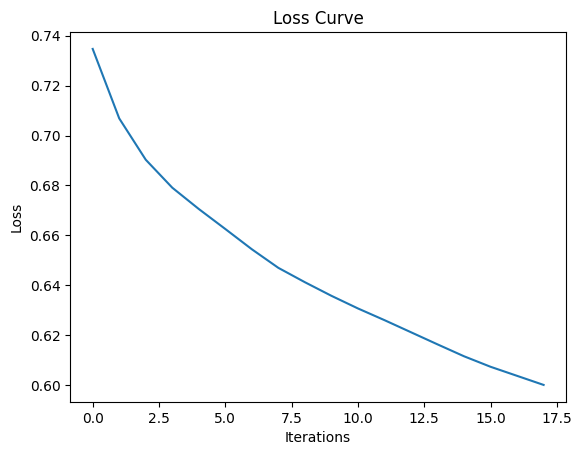

In [43]:
# Initialize the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=400, early_stopping=True)

# Train the model
mlp.fit(features_train, targets_train)

# Predict on the test set
targets_pred = mlp.predict(features_test)

# Calculate accuracy
accuracy = accuracy_score(targets_test, targets_pred)*100
print(f'Accuracy: {accuracy:.2f}%')

# Plotting the loss curve
plt.plot(mlp.loss_curve_)
plt.title('Loss Curve')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [16]:
# Define the model, loss function, and optimizer
# num_classes = len(encoder.classes_)
from sklearn.metrics import f1_score
num_classes = 2
# print(num_classes)
model = MLP(len(features.columns), 128, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)
loss_mlp = []
# Training function
def train_model(model, criterion, optimizer, dataloader, num_epochs=128):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_mlp.append(total_loss)
        # if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(dataloader):.4f}')

# Evaluation function
# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'F1 Score: {f1:.2f}')


# Execute training and evaluation
train_model(model, criterion, optimizer, train_dataloader, num_epochs=128)
evaluate_model(model, test_dataloader)

Epoch [1/128], Loss: 0.7069
Epoch [2/128], Loss: 0.6977
Epoch [3/128], Loss: 0.6928
Epoch [4/128], Loss: 0.6884
Epoch [5/128], Loss: 0.6797
Epoch [6/128], Loss: 0.6782
Epoch [7/128], Loss: 0.6724
Epoch [8/128], Loss: 0.6708
Epoch [9/128], Loss: 0.6664
Epoch [10/128], Loss: 0.6623
Epoch [11/128], Loss: 0.6583
Epoch [12/128], Loss: 0.6546
Epoch [13/128], Loss: 0.6534
Epoch [14/128], Loss: 0.6513
Epoch [15/128], Loss: 0.6445
Epoch [16/128], Loss: 0.6410
Epoch [17/128], Loss: 0.6400
Epoch [18/128], Loss: 0.6396
Epoch [19/128], Loss: 0.6369
Epoch [20/128], Loss: 0.6307
Epoch [21/128], Loss: 0.6304
Epoch [22/128], Loss: 0.6271
Epoch [23/128], Loss: 0.6280
Epoch [24/128], Loss: 0.6287
Epoch [25/128], Loss: 0.6289
Epoch [26/128], Loss: 0.6255
Epoch [27/128], Loss: 0.6217
Epoch [28/128], Loss: 0.6172
Epoch [29/128], Loss: 0.6194
Epoch [30/128], Loss: 0.6145
Epoch [31/128], Loss: 0.6135
Epoch [32/128], Loss: 0.6172
Epoch [33/128], Loss: 0.6097
Epoch [34/128], Loss: 0.6140
Epoch [35/128], Loss: 0

In [14]:
print(len(loss_mlp))
print(len(loss_en_mlp))
# import matplotlib.pyplot as plt


# Plotting the loss values
plt.figure(figsize=(10, 6))
plt.plot(loss_mlp, label='MLP', marker='o')
plt.plot(loss_en_mlp, label='Pre-trained MLP', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

128


NameError: name 'loss_en_mlp' is not defined